<a href="https://colab.research.google.com/github/briannalizbinoy/My-Projects/blob/main/3_Astrometry_Plate_Solving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install astropy
!pip install photutils
!pip install matplotlib astropy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import LogNorm
from astropy.coordinates import SkyCoord
import astropy.units as u
from pathlib import Path
from astropy.io import fits
from astropy.stats import sigma_clip
import astropy.units as u
from astropy.coordinates import SkyCoord
from photutils.detection import DAOStarFinder
import zipfile
import os
from glob import glob
from scipy.optimize import curve_fit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd

#Read the cleaned image (We use only a corner of one image for demonstration)
img = fits.open('/content/drive/MyDrive/26Proserpina/Cleaned/cleaned_20120119_0.fits')[0].data

ITERATION_NUM = 0

if ITERATION_NUM == 0:
    #Read in the star data from the cross matching
    star_data =  pd.read_csv('/content/drive/MyDrive/26Proserpina/Crossmatching/20120119_0')
elif ITERATION_NUM == 1:
    # #Read in the star data from the cross matching
    star_data =  pd.read_csv('/content/drive/MyDrive/26Proserpina/Crossmatching/20120119_0')

print(f"We have cross matched {len(star_data)} Stars! Here are the first few.")

star_data.head()

We have cross matched 376 Stars! Here are the first few.


,USNO-B1.0,RAJ2000,DEJ2000,USNO_approx_x,USNO_approx_y,Centroid_x,Centroid_y,Separation,R2mag,pmRA,pmDE
0,1166-0077064,81.064887,26.678423,1097.604855,29.072546,1096.380567,33.301900,4.402990,16.38,20.0,16.0
1,1166-0077389,81.189420,26.686753,1470.682241,50.743224,1471.061858,46.024744,4.733726,15.14,-14.0,0.0
2,1166-0077593,81.266709,26.688367,1702.016788,52.468326,1697.544254,56.432735,5.976629,16.72,0.0,0.0
3,1166-0076984,81.033073,26.689328,1003.049720,67.238277,1001.118299,63.168600,4.504737,16.48,0.0,0.0
4,1166-0077211,81.122920,26.694653,1272.158398,80.476344,1273.239092,84.617454,4.279800,16.03,0.0,0.0


In [ ]:
def convert2deg(ra, dec):
  coordinates = SkyCoord(ra, dec, unit=(u.hourangle, u.deg))
  ra_degree = coordinates.ra.deg
  dec_degree = coordinates.dec.deg
  return ra_degree, dec_degree

In [ ]:
def get_XY(ra, dec, alpha0, delta0):
    ra_rad = np.radians(ra)
    dec_rad = np.radians(dec)
    alpha0_rad = np.radians(alpha0)
    delta0_rad = np.radians(delta0)


    X = -(np.cos(dec_rad) * np.sin(ra_rad - alpha0_rad)) / (
            (np.cos(delta0_rad) * np.cos(dec_rad) * np.cos(ra_rad - alpha0_rad)) + np.sin(delta0_rad) * np.sin(dec_rad))

    Y = -((np.sin(delta0_rad) * np.cos(dec_rad) * np.cos(ra_rad - alpha0_rad)) - np.cos(delta0_rad) * np.sin(dec_rad)) / (
            (np.cos(delta0_rad) * np.cos(dec_rad) * np.cos(ra_rad - alpha0_rad)) + np.sin(delta0_rad) * np.sin(dec_rad))
    return X,Y




In [ ]:
usno_ra = star_data["RAJ2000"]
usno_dec = star_data["DEJ2000"]
ccd_x = star_data["Centroid_x"]
ccd_y = star_data["Centroid_y"]
usno_x_approx = star_data["USNO_approx_x"]
usno_y_approx = star_data["USNO_approx_y"]
usno_X = np.empty_like(usno_x_approx)
usno_Y = np.empty_like(usno_x_approx)

center_of_field = ['05 24 07.53', '+26 58 50.5']
alpha0, delta0 = convert2deg(*center_of_field)

for i in range(usno_ra.shape[0]):
    usno_X[i], usno_Y[i] = get_XY(usno_ra[i], usno_dec[i], alpha0, delta0)

In [ ]:
ccd_x = star_data["Centroid_x"]
ccd_y = star_data["Centroid_y"]
print(ccd_x)

0      1096.380567
1      1471.061858
2      1697.544254
3      1001.118299
4      1273.239092
          ...     
371    1884.046231
372    1884.569183
373    1883.798551
374    1435.481076
375    1366.597228
Name: Centroid_x, Length: 376, dtype: float64


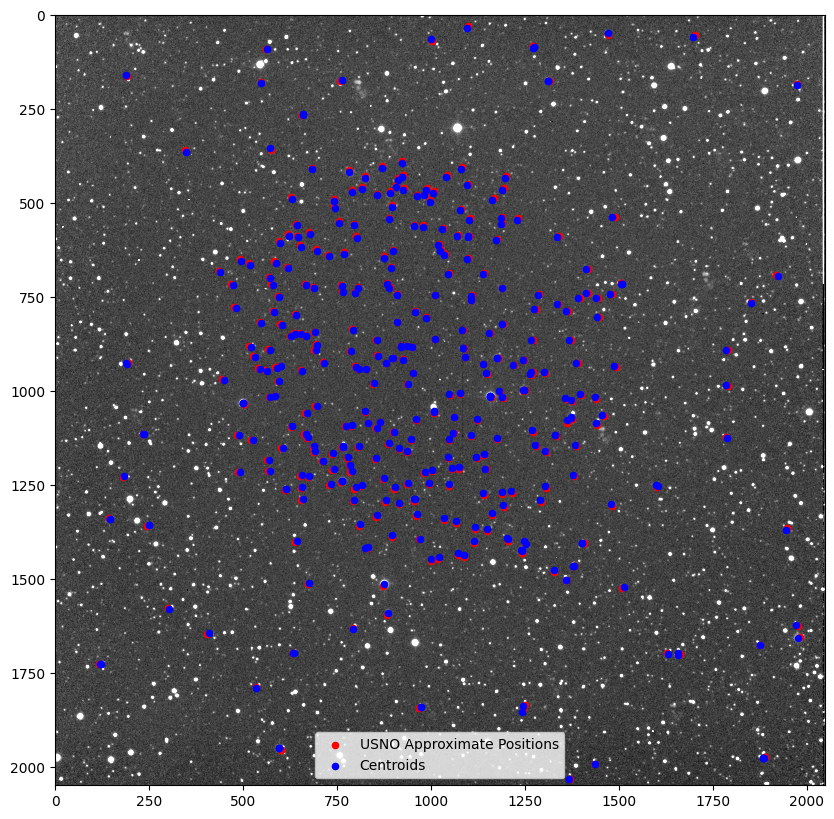

In [ ]:
#Let's Plot the data to see were we are at
plt.figure(figsize=(10,10))
contrast = 1 #higher number will make more contrast
vmin, vmax = np.percentile(img,contrast),np.percentile(img,100-contrast)
plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
plt.scatter(usno_x_approx, usno_y_approx,s=20,color='red',label='USNO Approximate Positions')
plt.scatter(ccd_x, ccd_y,s=20,color='blue',label='Centroids')
plt.legend()

In [ ]:
def get_T(ccd_x, ccd_y, usno_X, usno_Y): #ccd_x and ccd_y are pixel coordinates of our stars and usno_X and usno_Y are standard coordinates of our USNO stars
    # a_11, a_12, a_21, a_22, x_0, y_0 = params
    # X_transformed = a_11 * usno_X + a_12 * usno_Y + x_0
    # Y_transformed = a_21 * usno_X + a_22 * usno_Y + y_0

    #usno_x = B*c where c looks like (a_11, a_12, x_0)
    p = 0.009*2 #Remember, the pixels are binned in 2x2 squares
    f = 3454
    ratio = f/p
    B = []
    for i in range(len(usno_X)):
      l = [ratio*usno_X[i]]
      B.append(l)
    B = np.array(B)
    #c = (#transpose of B* B)^-1*(transpose of B)*a
    transpose_B = B.transpose()
    result = np.dot(transpose_B,B)
    inverse_result = np.linalg.inv(result)




In [ ]:
def get_T(ccd_x, ccd_y, usno_X, usno_Y):
  # for i in range(len(usno_X)):
  a = np.array([usno_X[0], usno_Y[0]])
  b = np.array([np.array(ccd_x)[0], np.array(ccd_y)[0]])
  # print(a.shape)
  # print(usno_X)

  T = np.linalg.lstsq(a.T,b.T)
  usno_x = np.dot(T, usno_X[0])
  usno_y = np.dot(T, usno_Y[0])
  # print(T)
  # a = [ratio*usno_X[1], ratio*usno_Y[1], 1]
  # b = [ratio*ccd_x[1], ratio*ccd_y[1]]
  # T = np.linalg.lstsq(a,b)
  # print(T)
    # print(b)
  return T, usno_x, usno_y

In [ ]:
a = np.array([[usno_X[0]], [usno_Y[0]], [1]])
b = np.array([[np.array(ccd_x)[0]], [np.array(ccd_y)[0]]])
# print(a.shape)
# print(usno_X)

T = np.linalg.lstsq(b.T,a.T)
usno_x = np.dot(T, usno_X[0])
usno_y = np.dot(T, usno_Y[0])
# print(T)
# a = [ratio*usno_X[1], ratio*usno_Y[1], 1]
# b = [ratio*ccd_x[1], ratio*ccd_y[1]]
# T = np.linalg.lstsq(a,b)
# print(T)
  # print(b)


<ipython-input-9-9043312db97e>:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  T = np.linalg.lstsq(b.T,a.T)


In [ ]:
a.shape

(3, 1)

In [ ]:
ccd_x = star_data["Centroid_x"]
ccd_y = star_data["Centroid_y"]
b = np.array([ccd_x, ccd_y])
print(b.shape)
a = np.array([usno_X, usno_Y, np.ones_like(usno_X)])
print(a.shape)

(2, 376)
(3, 376)


In [ ]:
a = np.array([usno_X, usno_Y, np.ones_like(usno_X)])
ccd_x = star_data["Centroid_x"]
ccd_y = star_data["Centroid_y"]
df = ccd_x
ccd_x = df.values
df = ccd_y
ccd_y = df.values
b = np.array([ccd_x, ccd_y])

T = np.linalg.lstsq(a.T,b.T)
print(np.shape(T))
T = T[0].T
usno_pixels = np.dot(T, a)
usno_x = usno_pixels[0]
usno_y = usno_pixels[1]
# usno_y = np.dot(T, usno_Y)
# print(len(usno_pixels[0]))

In [ ]:
#Let's Plot the data to see were we are at
plt.figure(figsize=(10,10))
contrast = 1 #higher number will make more contrast
vmin, vmax = np.percentile(img,contrast),np.percentile(img,100-contrast)
# plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
# plt.scatter(usno_x_approx, usno_y_approx,s=20,color='red',label='USNO Approximate Positions', alpha=0.5)
plt.scatter(ccd_x, ccd_y,s=20,color='red',label='Centroids', alpha=1)
plt.scatter(usno_x, usno_y,s=20,color='green',label='USNO Plate Solved Positions', alpha=0.5)
plt.legend()
plt.show()

print(len(ccd_x), len(usno_x))

In [ ]:
# For each star we have, calculate the distance between it and stars in the USNO catalog to find the closest one.
def distance(x1,y1,x2,y2):
    return np.sqrt((x1-x2)**2+(y1-y2)**2)

min_dists_before = np.empty_like(usno_x)
min_dists_after = np.empty_like(usno_x)
for i in range(usno_x.size):
    min_dists_before[i] = np.min(distance(usno_x_approx[i], usno_y_approx[i], ccd_x, ccd_y))
    min_dists_after[i] = np.min(distance(usno_x[i], usno_y[i], ccd_x, ccd_y))

CI_b = (np.percentile(min_dists_before,5),
      np.percentile(min_dists_before,95))
CI_a = (np.percentile(min_dists_after,5),
      np.percentile(min_dists_after,95))


plt.figure(figsize=(12,5))
plt.hist(min_dists_before,
         bins = "sturges",
         color = 'k',
         alpha = 0.5,
         label=f'Starting Transform, CI ({CI_b[0]:.1f},{CI_b[1]:.1f})')
plt.hist(min_dists_after,
         bins = "sturges",
         color = 'r',
         alpha = 0.5,
         label =f'After Solve Iteration, CI ({CI_a[0]:.1f},{CI_a[1]:.1f})')
plt.grid(alpha=0.5)
plt.xlabel("Distance Error [Pixels]", size = 16)
plt.ylabel("# of Stars", size = 16)
plt.legend()
plt.show()